### This code illustrates the fast AI implementation of the unsupervised "biological" learning algorithm from [Unsupervised Learning by Competing Hidden Units](https://doi.org/10.1073/pnas.1820458116) on MNIST data set. 
If you want to learn more about this work you can also check out this [lecture](https://www.youtube.com/watch?v=4lY-oAY0aQU) from MIT's [6.S191 course](http://introtodeeplearning.com/). 

This cell loads the data and normalizes it to the [0,1] range

In [1]:
import time
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
mat = scipy.io.loadmat('mnist_all.mat')

Nc=10
N=784
Ns=60000
M=np.zeros((0,N))
for i in range(Nc):
    M=np.concatenate((M, mat['train'+str(i)]), axis=0)
M=M/255.0

To draw a heatmap of the weights a helper function is created:

In [2]:
def draw_weights(synapses, Kx, Ky):
    yy=0
    HM=np.zeros((28*Ky,28*Kx))
    for y in range(Ky):
        for x in range(Kx):
            HM[y*28:(y+1)*28,x*28:(x+1)*28]=synapses[yy,:].reshape(28,28)
            yy += 1
    plt.clf()
    nc=np.amax(np.absolute(HM))
    im=plt.imshow(HM,cmap='bwr',vmin=-nc,vmax=nc)
    fig.colorbar(im,ticks=[np.amin(HM), 0, np.amax(HM)])
    plt.axis('off')
    fig.canvas.draw()   
    

This cell defines paramaters of the algorithm: `eps0` - initial learning rate that is linearly annealed during training; `hid` - number of hidden units that are displayed as an `Ky` by `Kx` array by the helper function defined above; `mu` - the mean of the gaussian distribution that initializes the weights; `sigma` - the standard deviation of that gaussian; `Nep` - number of epochs; `Num` - size of the minibatch; `prec` - parameter that controls numerical precision of the weight updates; `delta` - the strength of the anti-hebbian learning; `p` - Lebesgue norm of the weights; `k` - ranking parameter. 

In [3]:
eps0=2e-2    # learning rate
Kx=10
Ky=10
hid=Kx*Ky    # number of hidden units that are displayed in Ky by Kx array
mu=0.0
sigma=1.0
Nep=200      # number of epochs
Num=100      # size of the minibatch
prec=1e-30
delta=0.4    # Strength of the anti-hebbian learning
p=2.0        # Lebesgue norm of the weights
k=2          # ranking parameter, must be integer that is bigger or equal than 2

This cell defines the main code. The external loop runs over epochs `nep`, the internal loop runs over minibatches. For every minibatch the overlap with the data `tot_input` is calculated for each data point and each hidden unit. The sorted strengths of the activations are stored in `y`. The variable `yl` stores the activations of the post synaptic cells - it is denoted by g(Q) in Eq 3 of [Unsupervised Learning by Competing Hidden Units](https://doi.org/10.1073/pnas.1820458116), see also Eq 9 and Eq 10. The variable `ds` is the right hand side of Eq 3. The weights are updated after each minibatch in a way so that the largest update is equal to the learning rate `eps` at that epoch. The weights are displayed by the helper function after each epoch. 

<IPython.core.display.Javascript object>


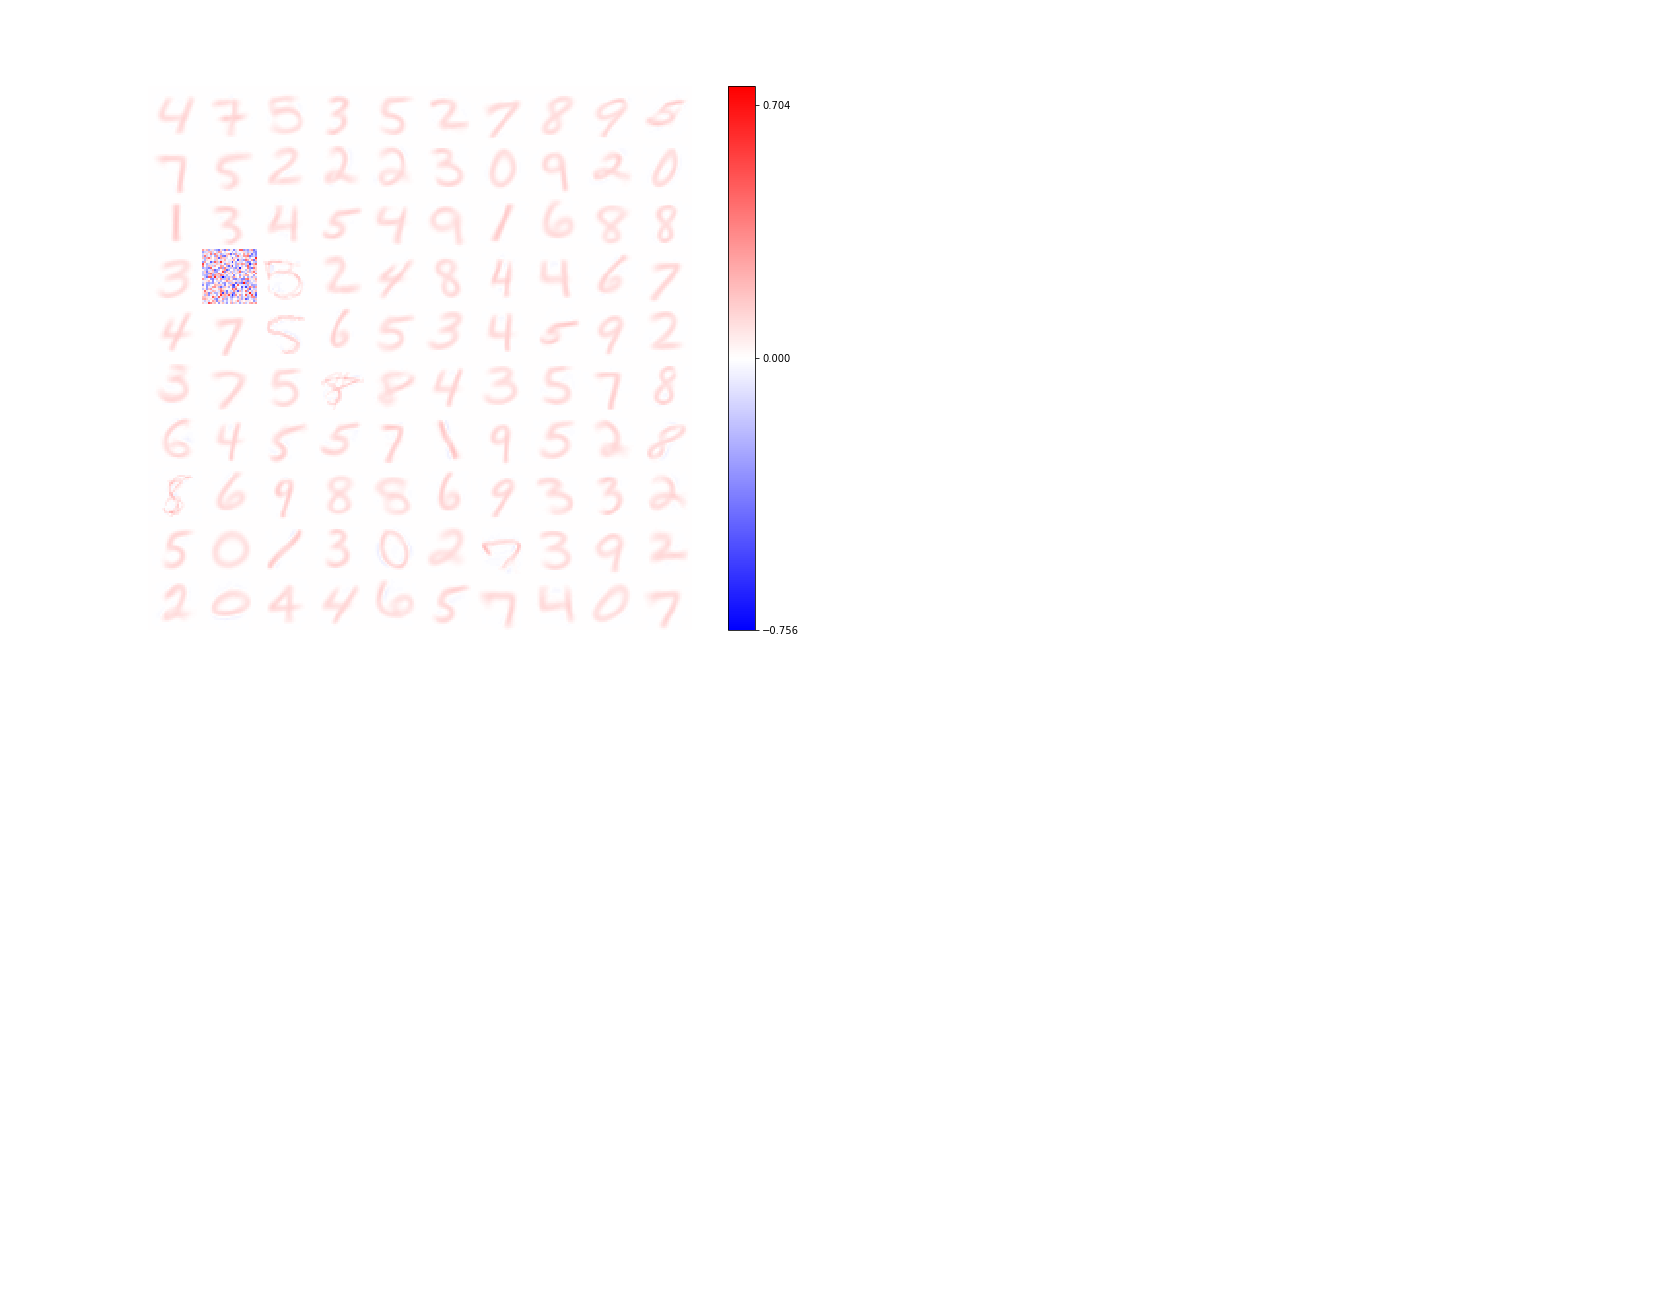

took 394.0830s to run 200 epochs


In [4]:
%matplotlib inline
%matplotlib notebook
fig=plt.figure(figsize=(12.9,10))

start  = time.time()
synapses = np.random.normal(mu, sigma, (hid, N))
for nep in range(Nep):
    eps=eps0*(1-nep/Nep)
    M=M[np.random.permutation(Ns),:]
    for i in range(Ns//Num):
        inputs=np.transpose(M[i*Num:(i+1)*Num,:])
        sig=np.sign(synapses)
        tot_input=np.dot(sig*np.absolute(synapses)**(p-1),inputs)
        
        y=np.argsort(tot_input,axis=0)
        yl=np.zeros((hid,Num))
        yl[y[hid-1,:],np.arange(Num)]=1.0
        yl[y[hid-k],np.arange(Num)]=-delta
        
        xx=np.sum(np.multiply(yl,tot_input),1)
        ds=np.dot(yl,np.transpose(inputs)) - np.multiply(np.tile(xx.reshape(xx.shape[0],1),(1,N)),synapses)
        
        nc=np.amax(np.absolute(ds))
        if nc<prec:
            nc=prec
        synapses += eps*np.true_divide(ds,nc)
        
    draw_weights(synapses, Kx, Ky)
    
print('took {:.4f}s to run {} epochs'.format(time.time() - start, Nep))

Below is a pytorch compatible version of the algorithm.

<IPython.core.display.Javascript object>


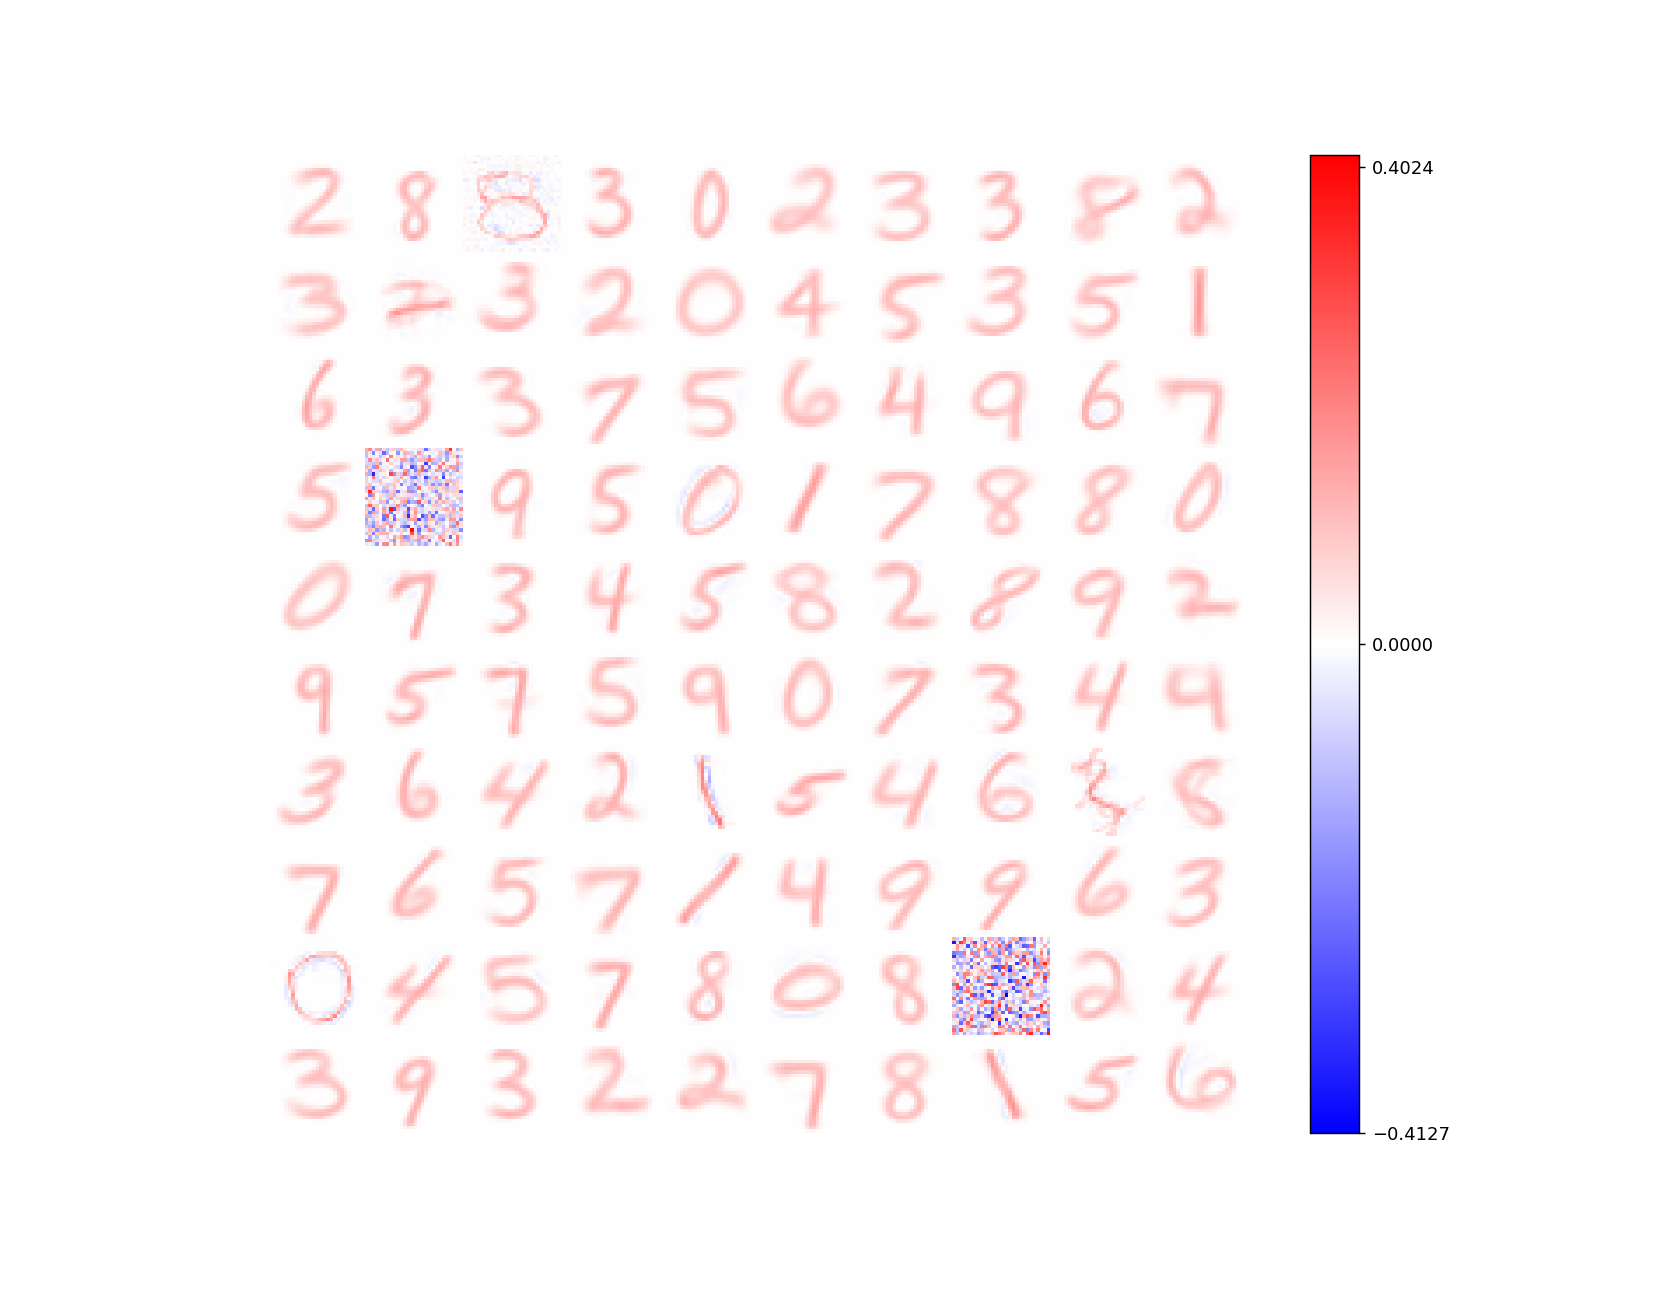

took 81.3884s to run 200 epochs


In [5]:
%matplotlib inline
%matplotlib notebook
fig=plt.figure(figsize=(12.9,10))

import torch
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
start  = time.time()

# wrap as Tensor
data = torch.Tensor(M).to(device)
synapses = torch.Tensor(hid, N).normal_(mu, sigma).to(device)

for epoch in range(Nep):
    # decay learning rate
    eps = eps0 * (1 - epoch / Nep)
    
    # shuffle your data
    data = data[torch.randperm(data.size(0))]
    
    # iterate over yoru data
    for i in range(Ns//Num):
        input = data[i*Num:(i+1)*Num].t()
        
        #tot_input = synapses.matmul(input)
        sig   = synapses.sign()
        tot_input = (sig * synapses.abs() ** (p-1)).matmul(input)
        
        # find indices maximizing the synapse
        _, indices = tot_input.topk(k, dim=0)
        best_ind, best_k_ind = indices[0], indices[k-1]
        
        yl = torch.zeros(hid, Num).to(device)
        yl[best_ind,   torch.arange(Num).to(device)] = 1.0
        yl[best_k_ind, torch.arange(Num).to(device)] = -delta
        
        xx = (yl * tot_input).sum(dim=1)
        ds = torch.matmul(yl, input.t()) - xx.unsqueeze(1) * synapses
        
        nc = max(ds.abs().max(), prec)
        
        # the actual update
        synapses += eps * ds / nc 

    draw_weights(synapses.cpu().data.numpy(), Kx, Ky)
print('took {:.4f}s to run {} epochs'.format(time.time() - start, Nep))